In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import losses
import sklearn
import random
import time

from sklearn import preprocessing, model_selection
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [ ]:
X_train = pd.read_csv("/content/X_train_30.csv")
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47992 entries, 0 to 47991
Data columns (total 30 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   v63       47992 non-null  int64  
 1   v5        47992 non-null  int64  
 2   v54       47992 non-null  int64  
 3   v64       47992 non-null  int64  
 4   v115      47992 non-null  int64  
 5   v56       47992 non-null  int64  
 6   v57       47992 non-null  int64  
 7   v93       47992 non-null  int64  
 8   v52_cs    47992 non-null  int64  
 9   v154      47992 non-null  int64  
 10  v277      47992 non-null  int64  
 11  v62       47992 non-null  int64  
 12  v243_cs   47992 non-null  int64  
 13  age       47992 non-null  int64  
 14  v196      47992 non-null  int64  
 15  v3        47992 non-null  int64  
 16  v261_ppp  47992 non-null  float64
 17  v52       47992 non-null  int64  
 18  v60       47992 non-null  int64  
 19  v263_cs   47992 non-null  int64  
 20  v52.1     47992 non-null  in

,v63,v5,v54,v64,v115,v56,v57,v93,v52_cs,v154,...,v52.1,v134,v153,v4,v160,v158,v2,v156,v155,v161
0,9,3,2,1,1,1,1,1,80403,4,...,1,0,1,2,1,5,1,5,4,5
1,-2,3,-2,-2,2,-2,-2,2,-3,1,...,-3,4,1,2,1,1,1,1,1,1
2,3,2,7,7,3,3,2,2,-3,10,...,-3,1,10,1,2,9,2,10,10,9
3,1,2,6,7,4,2,2,2,-3,7,...,-3,1,10,1,6,7,2,7,6,8
4,5,3,6,6,3,1,1,2,4005,9,...,2,0,10,2,3,3,1,3,10,9


In [ ]:
y_train = pd.read_csv("/content/full_y.csv")
y_train.drop('id', axis = 1, inplace = True)
y_train['label'].replace(-1, 0, inplace=True)
#y_train['x'].replace(-1, 0, inplace=True)
y_train.info()
y_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47992 entries, 0 to 47991
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       47992 non-null  int64
dtypes: int64(1)
memory usage: 375.1 KB


,x
0,2
1,2
2,4
3,3
4,3


# Neural Network

Split data into training, testing and validation set

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train,y_train,test_size = 0.2, random_state = 42)
# Create a validation dataset from training data
X_train, X_valid, y_train,y_valid = model_selection.train_test_split(X_train, y_train ,test_size=0.1,random_state=55)


In [ ]:
# create a normalization layer
normalizer = layers.Normalization()
# adapt the layer to the training data
normalizer.adapt(X_train.to_numpy())
# apply
normalized_X_train = normalizer(X_train)

In [ ]:
normalized_X_train

<tf.Tensor: shape=(34553, 30), dtype=float32, numpy=
array([[ 0.03503059, -1.6508241 ,  0.5852843 , ...,  0.5802922 ,
        -0.34934026, -0.46572292],
       [ 0.32043818, -0.6615093 ,  0.08249158, ..., -1.1004384 ,
        -1.5750778 , -0.46572292],
       [ 1.1766609 , -0.6615093 , -1.4258865 , ...,  0.02004869,
        -0.65577465, -1.0451391 ],
       ...,
       [-1.9628224 ,  1.3171203 , -0.9230938 , ..., -1.1004384 ,
        -1.5750778 , -1.6245553 ],
       [ 1.1766609 ,  1.3171203 ,  1.088077  , ..., -1.6606818 ,
        -0.34934026, -1.6245553 ],
       [ 0.8912533 ,  1.3171203 , -0.4203011 , ...,  0.86041397,
        -0.34934026,  0.9828176 ]], dtype=float32)>

Model building:

In [ ]:
np.random.seed(441)

input_dim = len(X_train.columns)

model = Sequential()
model.add(normalizer)
model.add(Dense(30, input_dim = input_dim , activation = 'relu'))
model.add(Dense(40, activation = 'relu', kernel_initializer = "he_normal"))
model.add(Dense(40, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))


model.compile(loss = 'sparse_categorical_crossentropy' ,
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics = ['accuracy'] )



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=3, min_lr=0.001)

Fitting the model



In [ ]:
m = model.fit(X_train, y_train, epochs = 30, batch_size = 100,
          validation_data=(X_valid, y_valid),
          callbacks = [callback,reduce_lr ])

Epoch 1/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5315 - loss: 1.0647 - val_accuracy: 0.5807 - val_loss: 0.9559 - learning_rate: 0.0100
Epoch 2/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5959 - loss: 0.9439 - val_accuracy: 0.5974 - val_loss: 0.9361 - learning_rate: 0.0100
Epoch 3/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5988 - loss: 0.9350 - val_accuracy: 0.5747 - val_loss: 0.9530 - learning_rate: 0.0100
Epoch 4/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6052 - loss: 0.9264 - val_accuracy: 0.5956 - val_loss: 0.9336 - learning_rate: 0.0100
Epoch 5/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6105 - loss: 0.9181 - val_accuracy: 0.6115 - val_loss: 0.9130 - learning_rate: 0.0100
Epoch 6/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6101 - loss: 0.9159 - val_accuracy: 0.5984 - val_loss: 0.9304 - learning_rate: 0.0100
Epoch 7/30
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6128 - loss: 0.9116 - 

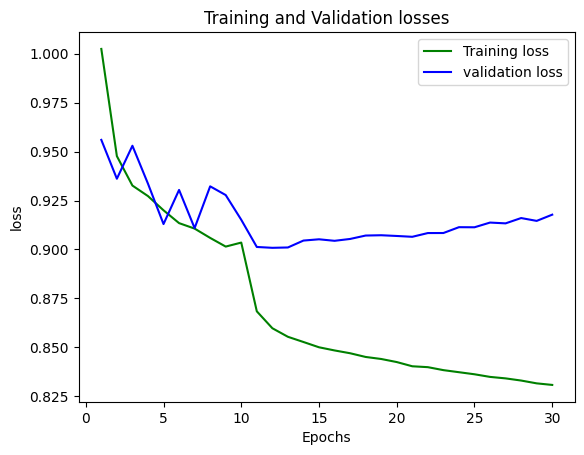

In [ ]:
train_loss = m.history['loss']
val_loss = m.history['val_loss']
train_acc = m.history['accuracy']
val_acc = m.history['val_accuracy']

epochs = range(1, len(val_acc) + 1)


plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and Validation losses')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

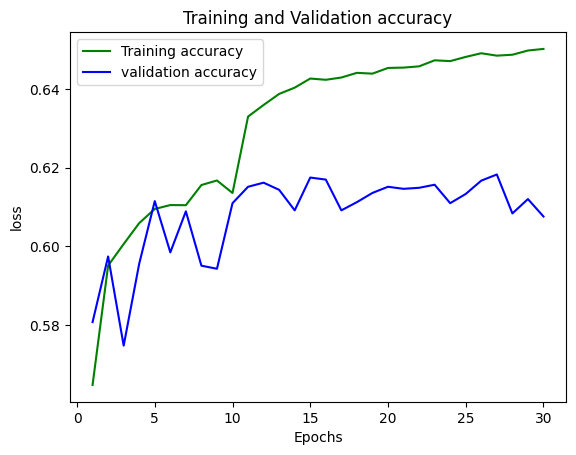

In [ ]:
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Testing

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6005 - loss: 0.9490
Loss:  0.9330831170082092
Accuracy:  0.6056880950927734


Run on the actual testing data

In [ ]:
test = pd.read_csv("/content/X_test_30.csv")
predictions = model.predict(test)

In [ ]:
predictions = np.array(predictions)
df = pd.DataFrame(predictions, columns=['no answer', 'very important', 'quite important', 'not important', 'not at all important'])

df.to_csv('tf_30_result_0325.csv', index=True)

## XGboosting

In [ ]:
X_train_xg = pd.read_csv('/content/dtrain_normalized.csv')
X_train_xg.drop('id', axis = 1, inplace = True)

X_test_xg = pd.read_csv('/content/dtest_normalized.csv')
X_test_xg.drop('id', axis = 1, inplace = True)

y_train = pd.read_csv('y_train.csv')
y_train.drop('id', axis = 1, inplace = True)
y_train['label'].replace(-1, 0, inplace=True)

In [ ]:
categorical_cols = X_train_xg.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_xg_encoded = pd.DataFrame(encoder.fit_transform(X_train_xg[categorical_cols]))
X_test_xg_encoded = pd.DataFrame(encoder.transform(X_test_xg[categorical_cols]))

# Concatenate encoded features with the rest of the data
X_train_xg_processed = pd.concat([X_train_xg.drop(categorical_cols, axis=1), X_train_xg_encoded], axis=1)
X_test_xg_processed = pd.concat([X_test_xg.drop(categorical_cols, axis=1), X_test_xg_encoded], axis=1)

X_train_xg_processed.columns = X_train_xg_processed.columns.astype(str)
X_test_xg_processed.columns = X_test_xg_processed.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
selector = SelectKBest(score_func=mutual_info_classif, k=500)
#X_train_selected = selector.fit_transform(X_train_xg_processed, y_train)


In [ ]:
X_selected = selector.fit_transform(X_train_xg_processed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
selected_indices = selector.get_support(indices=True)

In [ ]:
selected_features = X_train_xg_processed.columns[selected_indices].tolist()

In [ ]:
model_xgb = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=250, objective='multi:softmax', num_class= 5, seed = 10)
model_xgb.fit(X_train_xg_processed, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None, num_class=5,
              num_parallel_tree=None, ...)

In [ ]:
xgb_predictions = model_xgb.predict_proba(X_test_xg_processed)

In [ ]:
xgb_predictions

array([[0.00152706, 0.6676432 , 0.18943883, 0.12062407, 0.0207668 ],
       [0.01269702, 0.0938268 , 0.8119569 , 0.07570276, 0.00581663],
       [0.01384059, 0.1859661 , 0.45086572, 0.3349875 , 0.0143401 ],
       ...,
       [0.00704162, 0.17774007, 0.6596917 , 0.1420516 , 0.01347506],
       [0.01940492, 0.01257045, 0.26551652, 0.6238121 , 0.07869605],
       [0.00170761, 0.86938804, 0.11512843, 0.01228098, 0.0014949 ]],
      dtype=float32)

In [ ]:
cv_scores = cross_val_score(model_xgb, X_train_xg_processed, y_train, cv=5, scoring='accuracy')

In [ ]:
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Standard deviation of CV accuracy:", cv_scores.std())

Cross-validation scores: [0.64166667 0.64375    0.648125   0.640625   0.641875  ]
Mean CV accuracy: 0.6432083333333333
Standard deviation of CV accuracy: 0.0026568830944882905


In [ ]:
xgb_predictions_df = pd.DataFrame(
    xgb_predictions,
    columns=["no answer", "very important", "quite important", "not important", "not at all important"]
)

xgb_predictions_df.insert(0, 'id', xgb_predictions_df.index)

xgb_predictions_df.head()
xgb_predictions_df.to_csv('xgb_feature_df.csv', index=False, float_format='%.6f')

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the XGBClassifier
xgb_model = XGBClassifier(objective='multi:softmax')

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 4, 5],  # Try more values based on your dataset
    'learning_rate': [0.01, 0.1, 0.2],  # Also called 'eta'
    'n_estimators': [100, 150],
    'subsample': [0.8, 0.9, 1.0]  # Fraction of the training set used for each update
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1)

# Fit grid_search to the data
grid_search.fit(X_train_xg_processed[selected_features], y_train_xg)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


NameError: name 'y_train_xg' is not defined